# Linear Regression-Used Car Price Predictor

In [121]:
import warnings
warnings.filterwarnings('ignore')

In [122]:
#Importing required modules
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,inspect, func
from config import password

import seaborn as sns
import scipy.stats as ss
from collections import Counter
import math 
from scipy import stats
import datetime
import matplotlib
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from spark_sklearn import GridSearchCV
from spark_sklearn.util import createLocalSparkSession
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

from statsmodels.graphics.tsaplots import plot_acf

In [123]:
#Connecting to the sql database
connection_string = "postgres:"+password+"@localhost:5432/hondadb"
engine = create_engine(f'postgresql://{connection_string}')

In [124]:
df_cleaned = pd.read_sql("SELECT * FROM cleanedcardb2",
                     con=engine)

In [125]:
df_cleaned = df_cleaned[['Price', 'Milage', 'Year', 'Model', 'Car Type']]

In [126]:
df_cleaned.describe()

,Price,Milage,Year
count,23677.000000,23677.000000,23677.000000
mean,10.125652,83959.113359,2016.588588
std,0.600556,63801.946178,3.075055
min,7.309881,10.000000,1995.000000
25%,9.728300,37344.000000,2015.000000
50%,10.165275,69000.000000,2017.000000
75%,10.570984,116000.000000,2019.000000
max,12.042377,500000.000000,2021.000000


#### Label Encoding

In [127]:
features = ['Car Type', 'Model']
les = {}

for f in features:
  les[f] = preprocessing.LabelEncoder()
  les[f] = les[f].fit(df_cleaned[f])
  df_cleaned[f] = les[f].transform(df_cleaned[f])

#### Splitting Train and Test

In [128]:
# Splitting the dataset into train and test sets
train_set, test_set = train_test_split(df_cleaned, test_size = 0.3, random_state = 100)

# Separating target labels from the rest
df_train = train_set.drop("Price", axis=1) #train without target
df_price_train = train_set["Price"].copy() #target

df_test  = test_set.drop("Price", axis=1)
df_price_test = test_set["Price"].copy()

### Training A Linear Regression Model

#### Best Score Function

In [129]:
# This function returns the best score achieved by the model over all the cv splits
def best_score(forest, cv):
  best_score = 0
  for i in range(0, cv):
    items = list(map(lambda x: abs(x), forest.cv_results_['split'+str(i)+'_test_score']))
    arr = np.append(best_score, items)
    best_score = max(arr)
  
  return best_score

#### Best Param Function

In [130]:
# This functions returns the best combination of parameters, which allows to
# get the best score
def best_params(forest):
  return forest.cv_results_['params'][forest.cv_results_['rank_test_score'][0]-1]

#### Performance Metric Function

In [131]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true (y_true) and predicted (y_predict) values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### LINEAR REGRESSION

In [132]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import os

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet

class DFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_names].values

In [133]:
# Setting categorical and numerical attributes
df_features = ["Car Type", "Model"]
num_features = list(df_train.drop(df_features, axis=1))

# Building the Pipelines for categorical and numerical dataframes
numerical_pipeline = Pipeline([
    ("selector", DFSelector(num_features)),
    ("std_scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("selector", DFSelector(df_features)),
    ("encoder", OneHotEncoder(sparse=True))
])

# full_pipeline
full_pipeline = FeatureUnion(transformer_list =[
    ("num_pipeline", numerical_pipeline),
    ("cat_pipeline", categorical_pipeline)
])

In [134]:
# Apply the full pipeline
ohe_df_train = full_pipeline.fit_transform(df_train) # train set

In [135]:
from sklearn.linear_model import LinearRegression

sc = createLocalSparkSession().sparkContext

model = LinearRegression()
parameters = {'fit_intercept':[False], 'normalize':[True,False], 'copy_X':[True, False]}

# Spark parallelized GridSearchCV for hyperparameter tuning
gs = GridSearchCV(sc, estimator=model, param_grid=parameters, cv=3, n_jobs=-1, verbose=1, return_train_score=True)
lin_reg = gs.fit(ohe_df_train, df_price_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [136]:
# Best CV parameters
bp = best_params(lin_reg)
best_params(lin_reg)

lin_reg_model = LinearRegression(
                              fit_intercept=bp["fit_intercept"],
                              normalize=bp["normalize"],
                              copy_X=bp["copy_X"])
%time lin_reg_model.fit(ohe_df_train, df_price_train)

Wall time: 382 ms


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [137]:
# LinearRegression score for price prediction
ohe_df_test = full_pipeline.transform(df_test)

print("Best Linear Regression parameters:")
print(bp)
print("\nLinear Regressor score without CV on train set: %.3f" % lin_reg_model.score(ohe_df_train, df_price_train)) #score on train set
print("Linear Regression score without CV on test set: %.3f" % lin_reg_model.score(ohe_df_test, df_price_test)) # score on test set
print("Linear Regression Best score with CV=3: %.3f" % best_score(lin_reg, 3)) # -> best score on test set is high

Best Linear Regression parameters:
{'copy_X': True, 'fit_intercept': False, 'normalize': True}

Linear Regressor score without CV on train set: 0.929
Linear Regression score without CV on test set: 0.902
Linear Regression Best score with CV=3: 0.902


In [138]:
# Prediction on whole training set
from sklearn.metrics import mean_squared_error

price_predictions_train = lin_reg_model.predict(ohe_df_train) #using the whole training set for making prediction with the final model given by the best CV parameters

# Reversing np.log operation
price_predictions_train_normal = np.exp(price_predictions_train)
df_price_train_normal = np.exp(df_price_train)

# MSE between target values (i.e known) and predicted values
lin_mse = mean_squared_error(df_price_train_normal, price_predictions_train_normal)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

5207.558085525551

In [139]:
print(price_predictions_train_normal[1000:1020])
print('\n')
print(list(df_price_train_normal[1000:1020]))

[19291.49568245  4426.20198913 12048.71393267 14366.2171127
 13706.58559614 41557.85030623 19153.68309453  2759.24632336
 40444.89766053 16550.67051626 38180.93596893 24915.55045818
 23774.55208027 45394.13352509 38253.30283936 21774.79981754
 27148.76087411 46901.24595055 20187.11243569 18845.15319035]


[21979.99999999994, 4989.999999999975, 12999.000000000007, 15299.000000000007, 13949.999999999976, 43759.00000000033, 21899.999999999953, 4000.000000000007, 39887.99999999844, 18995.00000000009, 49989.999999999185, 19500.000000000044, 24471.000000000233, 71999.00000000343, 29990.000000001335, 17990.00000000001, 24990.000000000044, 52272.00000000254, 19995.00000000002, 23994.99999999888]


In [140]:
# Prediction on test set
price_predictions_test = lin_reg_model.predict(ohe_df_test)

# Reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
df_price_test_normal = np.exp(df_price_test)

final_mse = mean_squared_error(df_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse

6024.512547964637

In [141]:
print(price_predictions_test_normal[110:120]) #predictions on test set
print('\n')
print(list(df_price_test_normal[110:120])) #known values in test set

[43472.99248839 24778.34874317 38836.04418117 13364.84967799
 16570.60379272 14890.96224056 42856.51991327 24048.70480982
 48240.05178134 21174.19592519]


[42631.999999999236, 25125.000000000568, 39194.99999999909, 14997.999999999922, 15995.000000000025, 11198.00000000002, 38889.00000000188, 31849.999999999724, 52089.99999999806, 23729.99999999977]


In [142]:
from sklearn.metrics import r2_score
r2_score(df_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted')

0.875956483141765

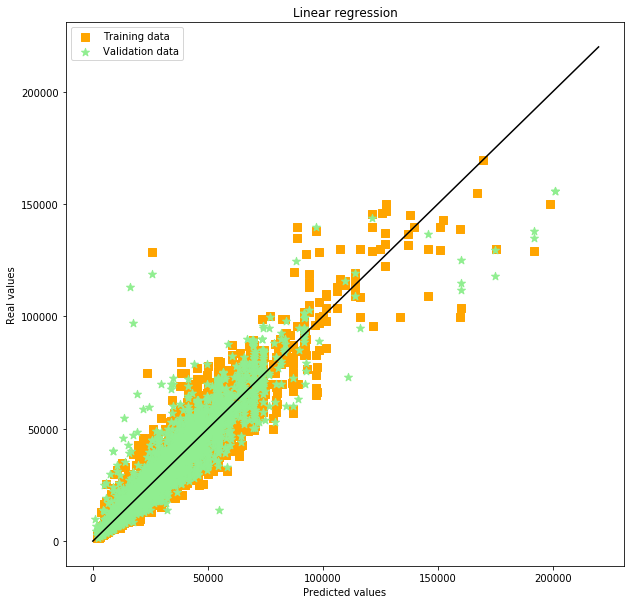

In [160]:
# Plot predictions
plt.figure(figsize=(10,10))
plt.scatter(price_predictions_train_normal, np.exp(df_price_train), s=50, c = "orange", marker = "s", label = "Training data")
plt.scatter(price_predictions_test_normal, np.exp(df_price_test), s=70 , c = "lightgreen", marker = "*", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 220000], [0, 220000], c = "black")
plt.show()

In [161]:
# Saving model for type prediction
pickle.dump(lin_reg_model, open("lin_reg_model_final.pkl", "wb"))

In [162]:
# Loading the model for type prediction
lin_reg_model = pickle.load(open("lin_reg_model_final.pkl", 'rb'))

#### Cross Validation

In [163]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [164]:
# Cross val score on training set, although we already used GridSearchCV 

train_scores = cross_val_score(lin_reg_model, ohe_df_train, np.exp(df_price_train),
                         scoring="neg_mean_squared_error", cv=3)
tree_rmse_scores = np.sqrt(-train_scores)

display_scores(tree_rmse_scores)

Scores: [6113.70630568 6050.82702268 6923.73086107]
Mean: 6362.754729812397
Standard deviation: 397.49978275940487


In [165]:
train_scores = cross_val_score(lin_reg_model, ohe_df_train, np.exp(df_price_train),
                          cv=3)

display_scores(train_scores)

Scores: [0.87639501 0.87810805 0.83825379]
Mean: 0.864252284165063
Standard deviation: 0.018397008098863524
